# Project Report: Predicting User Knowledge from Study Habits and Exam Performance

**DSCI 100 009: Group 23** <br>
Allison Fellhauer (38395166) <br>
Agastya Kaul (78851433) <br>
Grace Li (27986504) <br>
Xiangyuan Li (57380230) <br>

## 1. Introduction: Data set and background information

### 1.1 Background Information

#### 1.1.2 User Modeling and User Knowledge

User modeling is used to create a representation of a user based on their interactions with the system ([Chignell & Hancock, 1988](https://doi.org/10.1016/B978-0-444-70536-5.50051-8)). This model can be used to personalize and improve a user’s experience  ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). For example, in e-learning, a user model can be used to track a student’s knowledge level to adapt their learning experience ([Al-Tarabily et al. 2018](https://doi.org/10.1109/ACCESS.2018.2847334)) .

In the dataset [User Knowledge Modeling](https://doi.org/10.24432/C5231X), the authors investigate which user interactions should be used to create the best user knowledge model ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)). The goal is to dynamically adjust the student’s learning experience by building a model that classifies their knowledge-level ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

### 1.2 About the data set

**Our data set:** [User Knowledge Modeling](https://doi.org/10.24432/C5231X)

We have chosen to explore the User Knowledge Modeling data set, which is a data set that classifies users' knowledge of a topic (electrical DC machines) ([Kahraman et al. 2013](https://doi.org/10.1016/j.knosys.2012.08.009)).

There are 258 observations and 6 variables (5 features and 1 target) in the data set.

#### 1.2.1 Features (the predictors)
The features are elements of the user model that include two topics:

A) Goal topics (learning objects):
- The degree of time spent studying the material [STG, double]
- The degree of repetition of the material [SCG, double]
- The performance on exam [PEG, double]


B) Prerequisite topics:
- The degree of study time corresponding to the prerequisite objects [STR, double]
- The knowledge level of the prerequisite objects [LPR, double]

#### 1.2.2 Target (predicted class)
User knowledge level [UNS, factor]

Categorized into 4 levels:
- very low (beginner)
- low (intermediate)
- middle (expert) 
- high (advanced)

### 1.3 Our Question

**Can we predict the knowledge level of a user given their study habits and their performance on the exam?**

Our hypothesis was that if a user has high pre-requisite knowledge, good study habits of both pre-requisite and goal topics, and does well on the exam, we can infer that they have a greater knowledge level.

## 2. Methods

### 2.1 Loading necessary libraries and reading in the data

We began our project by loading in the necessary libraries.

In [155]:
#load all the necessary libraries
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("RColorBrewer")
library(RColorBrewer)
install.packages("kknn") 
library("kknn")
install.packages("themis")
library(themis)
install.packages("cowplot")
library(cowplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We then read the data from a URL.

In [30]:
#read data from the web (GitHub raw file)
url <- "https://raw.githubusercontent.com/afellhauer/DSCI_Group_Project/main/data/Data_User_Modeling_Dataset_Hamdi.csv"
knowledge <- read_csv(url)
head(knowledge)

Rows: 258 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): UNS
dbl (5): STG, SCG, STR, LPR, PEG

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


### 2.2 Make data usable and readable

Looking at the values, the format is tidy. To make the data usable, UNS (user_knowledge) needs to be converted from a character to a factor. To increase readability, we renamed all variables. We [checked for any missing data](https://www.tutorialspoint.com/dealing-with-missing-data-in-r) and [printed the result](https://www.geeksforgeeks.org/printing-output-of-an-r-program/). There are no missing values.

In [34]:
knowledge_mutate <- knowledge |>
    mutate(UNS = as_factor(UNS)) |> #change the class from a chr to a factor
    rename("study_time_goal" = STG, #relabel all variables to understand them better
           "repetition" = SCG,
           "study_time_related" = STR,
           "performance_related" = LPR, 
           "performance_goal" = PEG,
           "user_knowledge" = UNS) 
# |>
#     select(study_time_goal, repetition, performance_goal, user_knowledge)

head(knowledge_mutate)

missing <- sum(is.na(knowledge_mutate)) # check for missing values
print(paste("Number of missing values: ", missing))

study_time_goal,repetition,study_time_related,performance_related,performance_goal,user_knowledge
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


[1] "Number of missing values:  0"


### 2.3 Split the data into training and testing sets

To ensure reproducibility, we set the seed. We used a proportion of 0.75/0.25 for the training to testing ratio. We also stratified the data using user_knowledge, which is the class we are trying to predict. 

In [32]:
set.seed(200) #set seed to be reproducible
#create the initial split of the data
#stratify based on user_knowledge
knowledge_split <- initial_split(knowledge_mutate, prop = 0.75, strata = user_knowledge)

#collected the testing and training portions
knowledge_training <- training(knowledge_split)
knowledge_testing <- testing(knowledge_split)

glimpse(knowledge_training) #see that the number of rows is less than the dataset

Rows: 192
Columns: 6
$ study_time_goal     <dbl> 0.080, 0.180, 0.100, 0.090, 0.080, 0.200, 0.130, 0…
$ repetition          <dbl> 0.080, 0.180, 0.100, 0.300, 0.325, 0.450, 0.390, 0…
$ study_time_related  <dbl> 0.100, 0.550, 0.700, 0.680, 0.620, 0.280, 0.850, 0…
$ performance_related <dbl> 0.24, 0.30, 0.15, 0.18, 0.94, 0.31, 0.38, 0.71, 0.…
$ performance_goal    <dbl> 0.90, 0.81, 0.90, 0.85, 0.56, 0.78, 0.77, 0.90, 0.…
$ user_knowledge      <fct> High, High, High, High, High, High, High, High, Hi…


### 2.4 Summarize the data

We examined how balanced or unbalanced the data set is. We created a table that summarized the number of counts for each group of the user_knowledge variable. 

The very_low (beginner) knowledge level is not as represented in this data set.

In [4]:
summary_counts <- knowledge_training |>
    group_by(user_knowledge) |> #group based on the class
    summarize(count = n()) #gets the count (number of observations of each)
summary_counts

user_knowledge,count
<fct>,<int>
very_low,20
High,47
Low,59
Middle,66


**Table 1**: Proportion of observations classified as each user knowledge level (very_low, low, high, middle)

We then summarized the means of our predictors for each class.

In [5]:
summary <- knowledge_training |>
    select(user_knowledge, study_time_goal, repetition, performance_goal) |> 
    #select only the class and the predictors
    group_by(user_knowledge) |>
    summarize("mean_study_time" = mean(study_time_goal), "mean_repetition" = mean(repetition),
              "mean_exam_score" = mean(performance_goal)) 
    #get the mean for each predictor for each group
summary

user_knowledge,mean_study_time,mean_repetition,mean_exam_score
<fct>,<dbl>,<dbl>,<dbl>
very_low,0.3172000,0.1787500,0.0985000
High,0.4220000,0.4170426,0.7646809
Low,0.3249831,0.3482542,0.2386949
Middle,0.4147727,0.3676061,0.5430303


**Table 2**: Mean study time and mean exam score for each user knowledge level (very_low, low, middle, high)

### 2.5 Visualize the data

We visualized the distribution of the different groups according to their counts. Again, this highlights that the data is not completely balanced.

*To left align the caption, we used [this code](https://stackoverflow.com/questions/64701500/left-align-ggplot-caption)*.

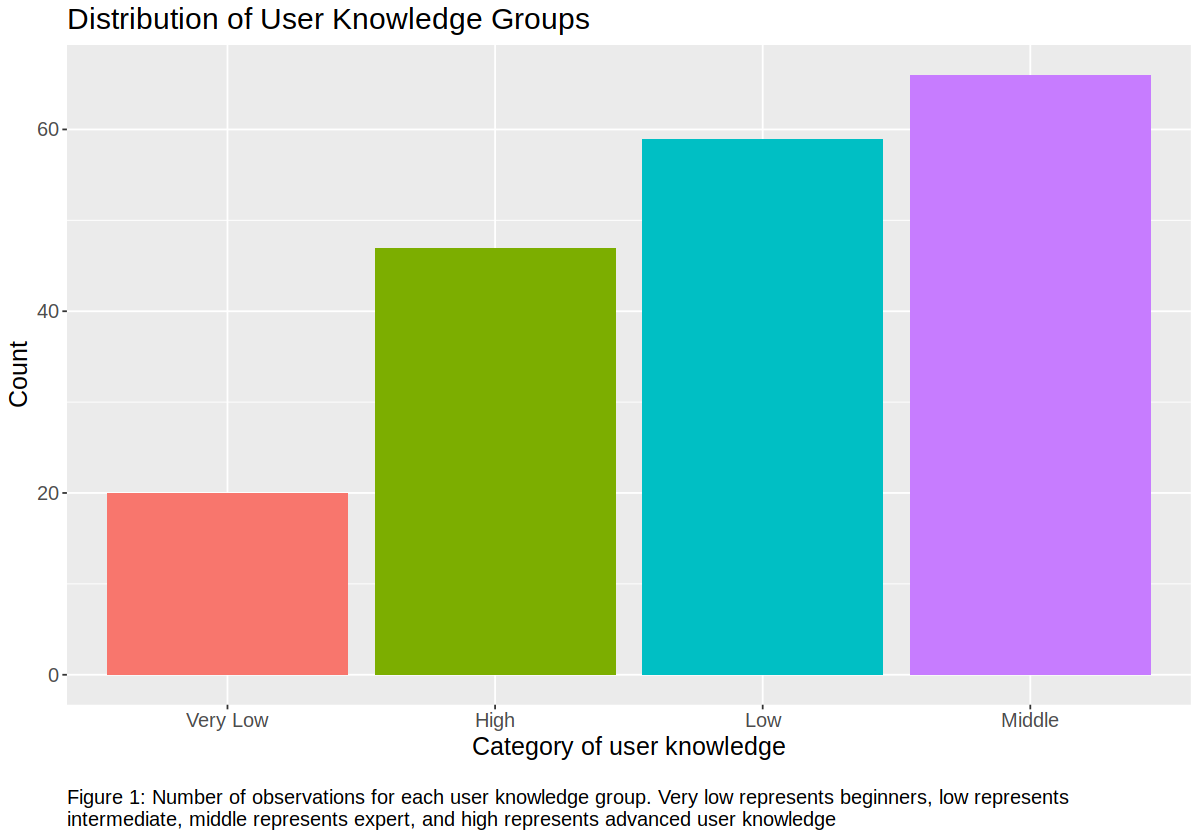

In [40]:
options(repr.plot.width = 10, repr.plot.height = 7)
knowledge_training_plot_distribution <- knowledge_training |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution <- knowledge_training_plot_distribution +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups") +
    labs(caption = "
Figure 1: Number of observations for each user knowledge group. Very low represents beginners, low represents 
intermediate, middle represents expert, and high represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution

### 2.6 Choosing our predictors
To determine which predictors to use for our analysis, we used scatter plots to visualize the clustering of user knowledge. We created four scatter plots to visualize performance on exam on learning objects vs. each predictor. We considered that performance on the exam of the goal topic (performance_goal) is relevant to user knowledge. Therefore, we kept performance_goal fixed on the y-axis. We then plotted all other predictors (study_time_goal, study_time_related, repetition, performance_related) on the x-axis to look for relationships.

In [7]:
# Plot a) 
knowledge_training_plot_pre_req_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("a) Goal Object Performance vs Pre-Requisite Study Time")

In [8]:
# Plot b)
knowledge_training_plot_repetition_vs_goal <- knowledge_training |>
    ggplot(aes(x = repetition, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of repetition on learning objects (goal)") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("b) Goal Object Performance vs Goal Repetition")

In [9]:
# Plot c)
knowledge_training_plot_study_vs_goal <- knowledge_training |>
    ggplot(aes(x = study_time_goal, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Degree of study time on learning objects (goal)") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("c) Goal Object Performance vs Goal Object Study Time")

In [37]:
# Plot d)
knowledge_training_plot_pre_req_performance_vs_goal <- knowledge_training |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")

We then used plot_grid to visualize all the plots together to make side-by-side comparisons.

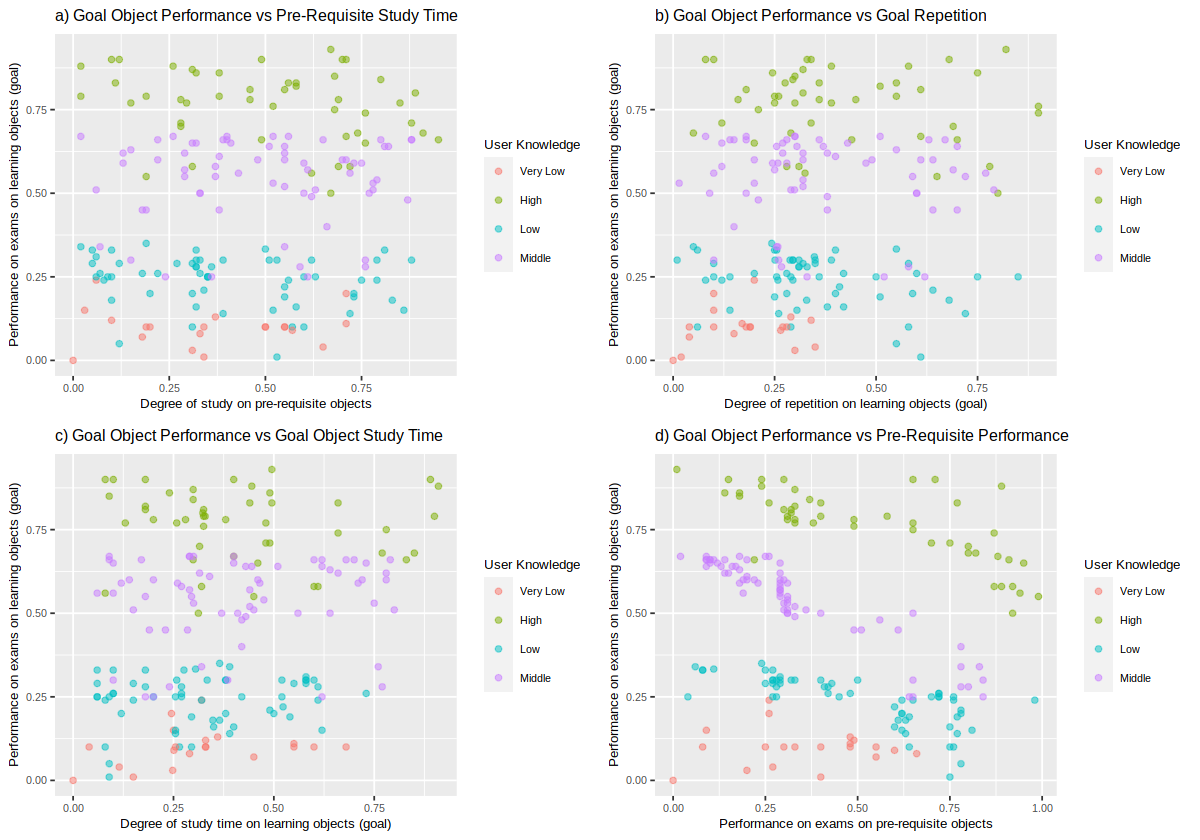

In [11]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot_grid(knowledge_training_plot_pre_req_study_vs_goal, knowledge_training_plot_repetition_vs_goal, knowledge_training_plot_study_vs_goal, 
          knowledge_training_plot_pre_req_performance_vs_goal, ncol = 2)

**Figure 2**: Grid plot of performance on exams of learning objects with four different predictor variables grouped by user knowledge category (very low, low, middle, high). The predictor variables are degree of study time on pre-requisite objects (a), degree of repetition on learning objects (b), degree of study on learning objects (c), and performance on exams of pre-requisite object (d).

Based on Figure 2, the most distinct clusters formed when plotting performance_related and performance_goal. Therefore, for our analysis, we will be using the following variables to be the predictors for user knowledge:
1. performance_related
2. performance_goal

Using performance as a predictor makes sense since student's knowledge of a topic is commonly evaluated using examinations. In addition, knowledge of pre-requisite topics is positively correlated with student achievement (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2630138/).

### 2.7 Analyse the data

As the data is unbalanced (see Fig. 1), we decide to create two models:
- model normal: no balancing
- model upsample: upsample so all ratios are the same as the category with the greatest count (Middle)

We decided to balance our data because in KNN classification, class imbalance can heavily affect the accuracy of the system. If one label has more data points, it's likelihood of being picked will increase, even if the patterns in the data show otherwise.

#### 2.7.1 Upsample the dataset

Our approach to balancing the data is to up-sample. We will accomplish this by creating a recipe with step_upsample applied to the user_knowledge variable and then applying "bake()" to produce a new up-sampled training data set. This new data set will be called knowledge_upsample.

In [115]:
set.seed(59)
# create a recipe to up-sample the current data set using step_upsample()
knowledge_recipe_up <- recipe(user_knowledge ~ performance_related + performance_goal, data = knowledge_training) |>
    step_upsample(user_knowledge, over_ratio = 1, skip = FALSE)

# prep the recipe
knowledge_prep_up <- knowledge_recipe_up |> prep() 

# bake the recipe to apply the changes to the data set
knowledge_upsampled <- bake(knowledge_prep_up, knowledge_training)

# visualize the changes in proportion
upsample_size <- knowledge_upsampled |> nrow()
upsampled_props <- knowledge_upsampled |>
    group_by(user_knowledge) |>
    summarize(distribution_upsampling = n() / upsample_size,
             count_upsampling = n())

knowledge_size <- knowledge_training |> nrow()
knowledge_props <- knowledge_training |>
    group_by(user_knowledge) |>
    summarize(distribution_no_upsampling = n() / knowledge_size, 
             count_no_upsampling = n()) |>
    merge(upsampled_props)
knowledge_props

user_knowledge,distribution_no_upsampling,count_no_upsampling,distribution_upsampling,count_upsampling
<fct>,<dbl>,<int>,<dbl>,<int>
High,0.2447917,47,0.25,66
Low,0.3072917,59,0.25,66
Middle,0.3437500,66,0.25,66
very_low,0.1041667,20,0.25,66


**Table 2**: Summary of the upsampled data set demonstrating the even ratios.

We then plot the distribution to see if the counts are all the same for Very Low, Low, Medium, and High.

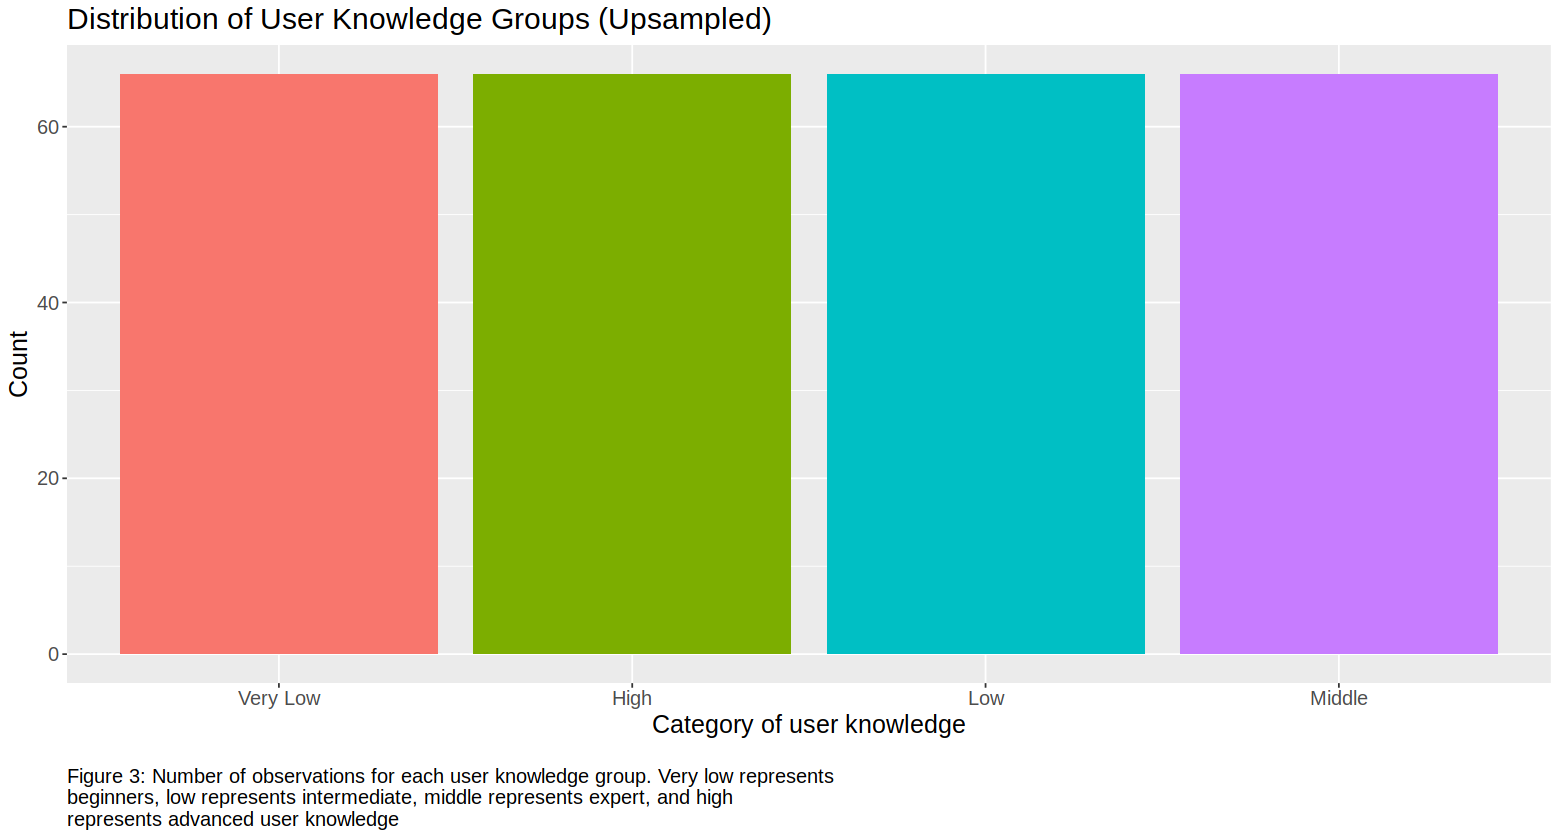

In [116]:
knowledge_training_plot_distribution_up <- knowledge_upsampled |>
    ggplot(aes(x = fct_recode(user_knowledge, "Very Low" = "very_low"), fill = user_knowledge)) + #change the label of very_low to Very Low
    geom_bar() + #use the default stat = "count"
    xlab("Category of user knowledge") +
    ylab("Count")

#make the plot look nicer
knowledge_training_plot_distribution_up <- knowledge_training_plot_distribution_up +
    theme(text = element_text(size = 15), legend.position = "none", #remove the legend
         plot.caption = element_text(hjust = 0)) + #set the text to left align
    ggtitle("Distribution of User Knowledge Groups (Upsampled)") +
    labs(caption = "
Figure 3: Number of observations for each user knowledge group. Very low represents 
beginners, low represents intermediate, middle represents expert, and high 
represents advanced user knowledge") +
    scale_color_brewer(palette = "Set2") #set the color palette
    
knowledge_training_plot_distribution_up

#### 2.7.2 Create a recipe for each dataset using our predictors and scale the values

We created recipes for each model (balanced and unbalanced). We do not need to center the data as it has already been centered.

In [117]:
# unbalanced
knowledge_recipe <- recipe(user_knowledge ~ performance_goal + performance_related, data = knowledge_training) |>
    step_scale(all_predictors())

In [118]:
# balanced
knowledge_recipe_upsampled <- recipe(user_knowledge ~ performance_related + performance_goal, data = knowledge_upsampled) |>
    step_scale(all_predictors())

#### 2.7.3 Create two KNN models

Using the nearest_neighbor function, we created a model for both the balanced and unbalanced training sets.

In [140]:
# unbalanced
# create a knn classification model and set the neighbors to tune()
set.seed(100)
knowledge_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
  set_engine("kknn") |>
  set_mode("classification")

#### 2.7.4 Tune the model using 5-fold cross-validation

We split each dataset into 5 folds for cross validation, running the model using k values 1 to 20. We then collected the estimate accuracy for each.

In [142]:
# unbalanced
# create a sequence of values from 1 to 20
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1)) 

# split the training data into 5 folds
knowledge_vfold <- vfold_cv(knowledge_training, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
knowledge_results <- workflow() |>
  add_recipe(knowledge_recipe) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies <- knowledge_results |>
  filter(.metric == "accuracy")

In [141]:
# balanced
# split the training data into 5 folds
knowledge_vfold_up <- vfold_cv(knowledge_upsampled, v = 5, strata = user_knowledge)

# tune the model and collect the accuracy
# use the same sequence of values from unbalanced (1-20)
knowledge_results_up <- workflow() |>
  add_recipe(knowledge_recipe_upsampled) |>
  add_model(knowledge_spec) |>
  tune_grid(resamples = knowledge_vfold_up, grid = k_vals) |>
  collect_metrics() 

# filter the results for accuracies
accuracies_up <- knowledge_results_up |>
  filter(.metric == "accuracy")

#### 2.7.5 Plot estimate of accuracy vs. number of neighbors

In [133]:
# unbalanced
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.87, 1.0) +
    ggtitle("a) Estimate of Accuracy vs. Number of Neighbors (Unbalanced)")

In [134]:
# balanced
accuracy_vs_k_upsampled <- ggplot(accuracies_up, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line(color = "blue") +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12), plot.caption = element_text(hjust = 0)) +
    scale_x_continuous(breaks = 1:20) +
    ylim(0.87, 1.0) +
    ggtitle("b) Estimate of Accuracy vs. Number of Neighbors (Balanced)")

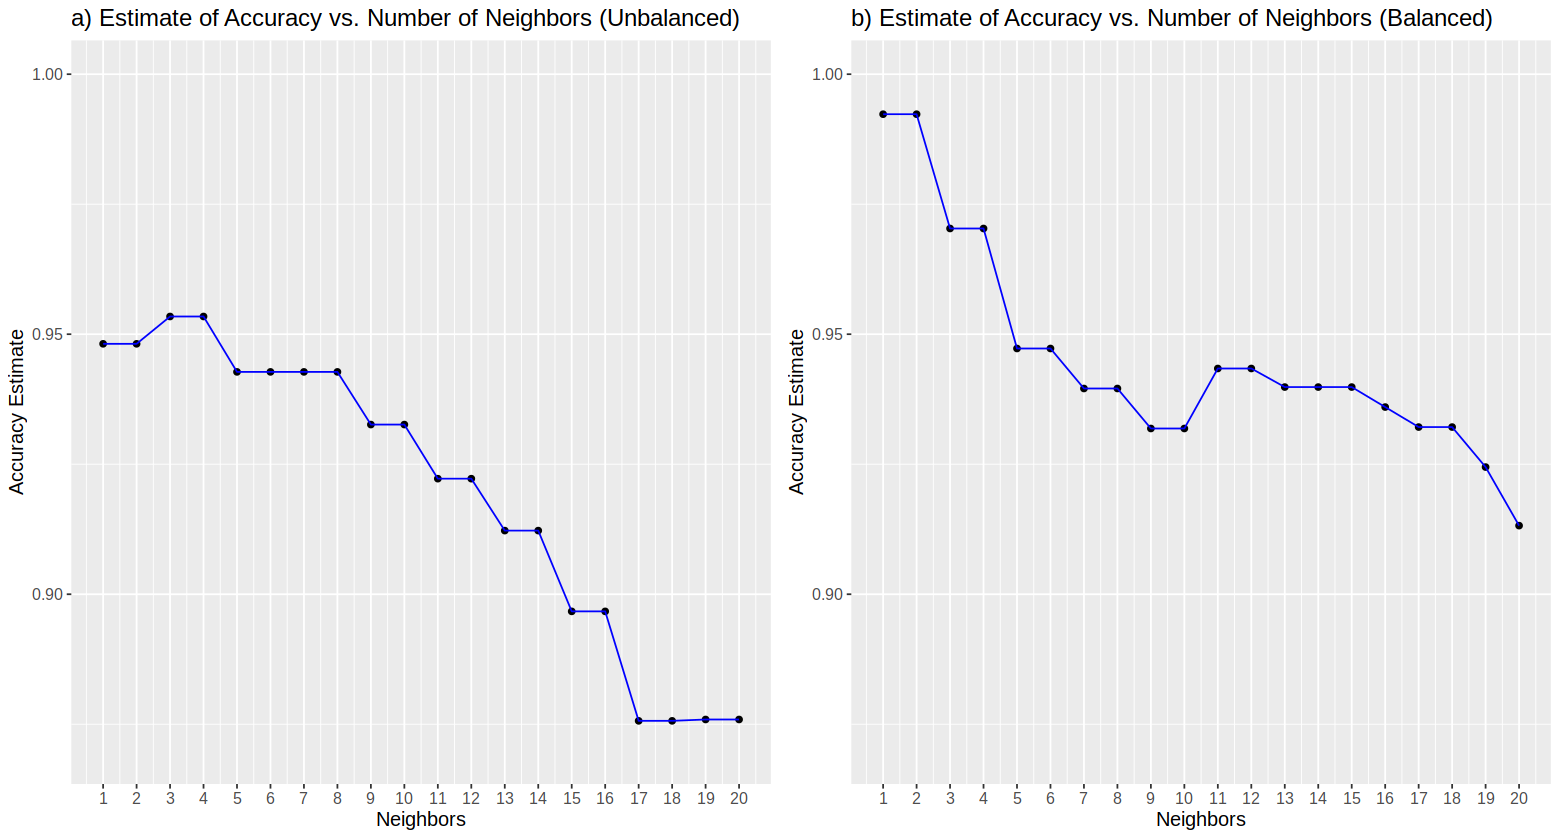

In [135]:
options(repr.plot.width = 13, repr.plot.height = 7)
plot_grid(accuracy_vs_k, accuracy_vs_k_upsampled)

**Figure 4**: Side by side comparison of estimate accuracy vs. number of neighbors for unbalanced (a) and balanced (b) KNN models after tuning the models.

#### 2.7.6 Choose the appropriate K-value for the training set

Based on Figure 4, we chose K = 3 for both the balanced and unbalanced models. For the unbalanced model, we determined the the accuracy was highest and accuracy changes the smallest amount if we increase or decrease K (Timbers et al., 2023). The same logic is used for the balanced model, except we chose K = 3 instead of K = 1 or K = 2 to avoid overfitting (Timbers et al., 2023). Furthermore, choosing K = 3 is advantageous as it is less likely to result in a tie for our classification.

#### 2.7.7 Create the KNN model using the selected K-value

Tuning the models results in the same number of neighbors, so we run nearest_neighbor once.

In [16]:
know_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")
know_spec_best

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


#### 2.7.8 Train the classifier using the training set

In [143]:
# unbalanced
#Create new workflow using the training set
knowledge_best <- workflow() |>
    add_recipe(knowledge_recipe) |>
    add_model(know_spec_best)|>
    fit(knowledge_training)
knowledge_best

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.05208333
Best kernel: rectangular
Best k: 3

In [146]:
# balanced
#Create new workflow using the training set
knowledge_best_upsampled <- workflow() |>
    add_recipe(knowledge_recipe_upsampled) |>
    add_model(know_spec_best)|>
    fit(knowledge_upsampled)
knowledge_best_upsampled

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.02272727
Best kernel: rectangular
Best k: 3

## 3. Analysis

After creating the two models (knowledge_best and knowledge_best_upsampled), we proceeded to evaluate our models using the testing set.

### 3.1 Predict the labels for the unseen testing set

In [150]:
# unbalanced
#Predicting the testing set
predict_test <- predict(knowledge_best, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_test <- predict_test |> 
    metrics(truth = user_knowledge, estimate = .pred_class)

accuracy_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9696970
kap,multiclass,0.9567213


In [151]:
# balanced
#Predicting the testing set
predict_test_up <- predict(knowledge_best_upsampled, knowledge_testing) |>
    bind_cols(knowledge_testing)

accuracy_test_up <- predict_test_up |> 
    metrics(truth = user_knowledge, estimate = .pred_class)

accuracy_test_up

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9545455
kap,multiclass,0.9350394


### 3.2 Create confusion matrices for each model

In [157]:
# unbalanced
confusion_matrix <- predict_test |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix

          Truth
Prediction very_low High Low Middle
  very_low        4    0   1      0
  High            0   16   0      1
  Low             0    0  23      0
  Middle          0    0   0     21

In [159]:
# balanced
confusion_matrix_up <- predict_test_up |> 
      conf_mat(truth = user_knowledge, estimate = .pred_class)
confusion_matrix_up

          Truth
Prediction very_low High Low Middle
  very_low        4    0   1      0
  High            0   16   0      1
  Low             0    0  23      1
  Middle          0    0   0     20

### 3.3 Visualize classification

In [169]:
knowledge_training_truth <- predict_test |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")
knowledge_training_predicted <- predict_test |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(.pred_class, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")

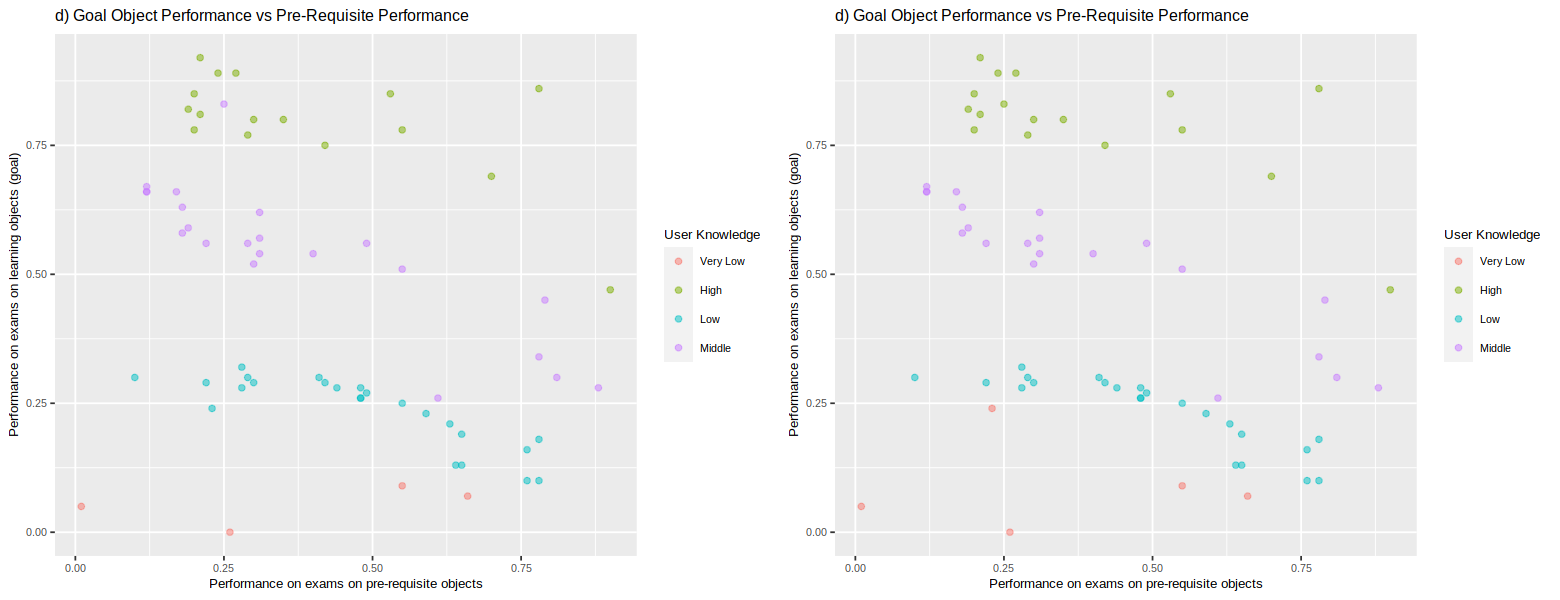

In [170]:
options(repr.plot.width = 13, repr.plot.height = 5)
plot_grid(knowledge_training_truth, knowledge_training_predicted)

In [171]:
knowledge_training_truth_up <- predict_test_up |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(user_knowledge, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")
knowledge_training_predicted_up <- predict_test_up |>
    ggplot(aes(x = performance_related, y = performance_goal, 
               color = fct_recode(.pred_class, "Very Low" = "very_low"))) + #change the label of very_low to Very Low
    geom_point(alpha = 0.5) +
    xlab("Performance on exams on pre-requisite objects") +
    ylab("Performance on exams on learning objects (goal)") +
    labs(color = "User Knowledge") +
    theme(text = element_text(size = 8), plot.caption = element_text(hjust = 0)) +
    ggtitle("d) Goal Object Performance vs Pre-Requisite Performance")

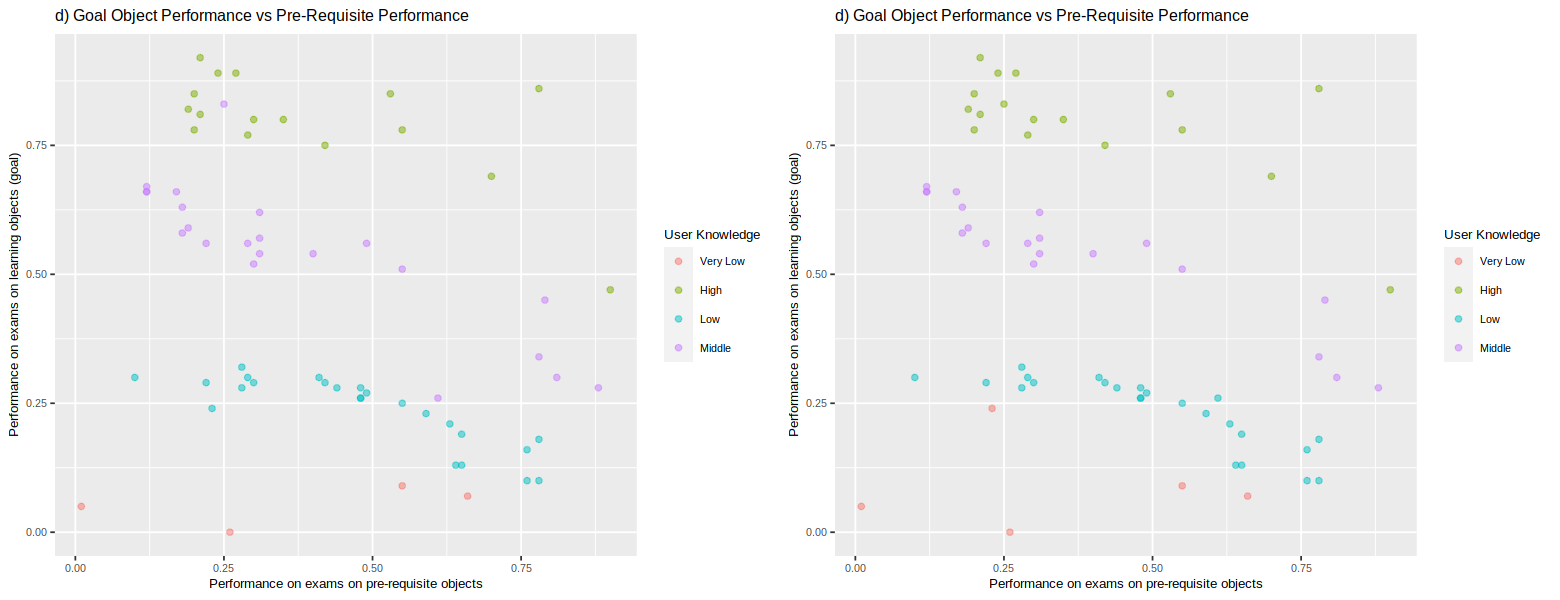

In [172]:
options(repr.plot.width = 13, repr.plot.height = 5)
plot_grid(knowledge_training_truth_up, knowledge_training_predicted_up)

## References

3 Timbers, T., Campbell, T., & Lee, M. (2023) Data Science: A First Introduction. CRC Press, Taylor & Francis Group. https://datasciencebook.ca/